In [1]:
 # import modules
import pandas as pd
import numpy as np

from hepqpr.qallse.plotting import *
from hepqpr.qallse import *

# initialise the plotting module in "notebook" mode
set_notebook_mode()

# initialise matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# initialise the logging module
import logging
logging.basicConfig(level=logging.INFO)
logging.getLogger('hepqpr').setLevel(logging.DEBUG)

In [2]:
# setup matplotlib
import matplotlib

# set big font in plots
SMALL_SIZE = 14
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

# Prepare data

## Load from filesystem

In [3]:
path = '~/git/quantum-annealing-project/trackml-data/train_100_events/event000001000'

hits = pd.read_csv(path + '-hits.csv').set_index('hit_id', drop=False)
hits.index.rename('idx')

truth = pd.read_csv(path + '-truth.csv').set_index('hit_id', drop=False)
truth.index.rename('idx')

hits = hits[hits.volume_id.isin([8,13,17])]
truth = truth.loc[hits.index]

_ = _

In [4]:
len(hits), len(truth[truth.particle_id != 0])

(65518, 52482)

## Prepare datasets

In [5]:
hits['r'] = np.sqrt(hits.x**2 + hits.y**2)

df = hits.join(truth, rsuffix='_', how='inner')
df = df[hits.volume_id.isin([8,13,17])]

### Keep true hits only, remove duplicates

In [6]:
df = df[df.particle_id != 0]
df.drop_duplicates(['particle_id', 'volume_id', 'layer_id'], keep='first', inplace=True)

### Apply a 1GeV cut

In [7]:
df = df[np.sqrt(df.tpx ** 2 + df.tpy ** 2) > 1]

In [39]:
hits = hits.loc[df.index]
truth = truth.loc[df.index]
len(hits), truth.particle_id.nunique()

(6438, 1101)

### Add volyer info

In [9]:
hits['volayer'] = [Volayer.get_index(tuple(i)) for i in hits[['volume_id', 'layer_id']].values]

In [10]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,r,volayer
hit_id,,,,,,,,,
16946,16946,-31.144400,-7.68151,-284.714,8,2,33,32.077706,0
16951,16951,-24.658900,-20.33090,-315.132,8,2,34,31.959456,0
16971,16971,-0.557692,-31.95380,-311.788,8,2,36,31.958666,0
16977,16977,-4.841760,-31.71210,-321.638,8,2,36,32.079587,0
16987,16987,10.351200,-30.21100,-315.857,8,2,37,31.935120,0


# Analysis

In [11]:
len(hits), truth.particle_id.nunique()

(6438, 1101)

In [12]:
truth.groupby('particle_id').particle_id.count().describe()

count    1101.000000
mean        5.847411
std         3.299913
min         1.000000
25%         2.000000
50%         6.000000
75%         9.000000
max        10.000000
Name: particle_id, dtype: float64

## Prepare doublets

In [13]:
true_tracks = recreate_tracks(hits, truth)
true_doublets = tracks_to_xplets(true_tracks, x=2)

doublets = pd.DataFrame(true_doublets, columns=['start', 'end'])

doublets['dr'] = hits.loc[doublets.end].r.values - hits.loc[doublets.start].r.values 
doublets['dz'] = hits.loc[doublets.end].z.values - hits.loc[doublets.start].z.values 

doublets['rz_angle'] = np.arctan2(doublets.dz, doublets.dz)
doublets['volayer_span'] = np.abs(hits.loc[doublets.end].volayer.values - hits.loc[doublets.start].volayer.values)
doublets.head(6)

,start,end,dr,dz,rz_angle,volayer_span
0,23346,31387,40.713787,77.2798,0.785398,1
1,31387,38927,43.413342,82.3950,0.785398,1
2,38927,45412,55.846713,105.8880,0.785398,1
3,45412,77184,87.735818,165.8420,0.785398,1
4,77184,84457,102.924159,195.8000,0.785398,1
5,84457,91226,136.779594,260.0000,0.785398,1


In [14]:
doublets[['rz_angle', 'volayer_span']].describe()

,rz_angle,volayer_span
count,5337.000000,5337.000000
mean,-0.779217,1.029043
std,1.569164,0.171256
min,-2.356194,1.000000
25%,-2.356194,1.000000
50%,0.000000,1.000000
75%,0.785398,1.000000
max,0.785398,3.000000


In [15]:
doublets.volayer_span.value_counts()

1    5185
2     149
3       3
Name: volayer_span, dtype: int64

## Prepare triplets

In [16]:
def compute_rz_angle(h1, h2):
     return np.arctan2(hits.r.get(h2) - hits.r.get(h1), hits.z.get(h2) - hits.z.get(h1))

In [17]:
true_triplets = tracks_to_xplets(true_tracks, x=3)

triplets = pd.DataFrame(true_triplets, columns=['s', 'm', 'e'])

drz = [angle_diff(compute_rz_angle(s, m), compute_rz_angle(m, e)) for s,m,e in triplets.values]
curv = [curvature(*hits.loc[t][['x','y']].values) for t in triplets.values]

triplets['drz'] = drz
triplets['curv'] = curv

triplets['volayer_span'] = np.abs(hits.loc[triplets.e].volayer.values - hits.loc[triplets.s].volayer.values)

triplets.head()

,s,m,e,drz,curv,volayer_span
0,23346,31387,38927,0.000044,-0.000501,2
1,31387,38927,45412,0.000407,-0.000617,2
2,38927,45412,77184,0.001266,-0.000547,2
3,45412,77184,84457,0.002639,-0.000522,2
4,77184,84457,91226,0.000326,-0.000555,2


## Analyse triplets

In [18]:
triplets[['drz', 'curv', 'volayer_span']].describe()

,drz,curv,volayer_span
count,4377.000000,4377.000000,4377.000000
mean,0.006033,-0.000001,2.044551
std,0.032474,0.000656,0.211805
min,0.000000,-0.016020,2.000000
25%,0.000370,-0.000411,2.000000
50%,0.001120,-0.000104,2.000000
75%,0.003703,0.000421,2.000000
max,0.971740,0.017392,4.000000


In [19]:
triplets.volayer_span.value_counts()

2    4187
3     185
4       5
Name: volayer_span, dtype: int64

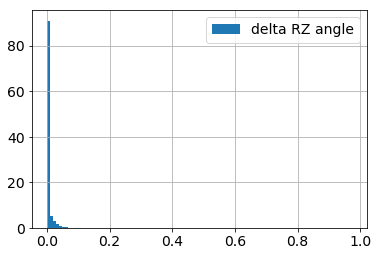

In [35]:
plt.figure()
triplets.drz.hist(density=True, bins=100, label='delta RZ angle')
plt.legend()
_ = _

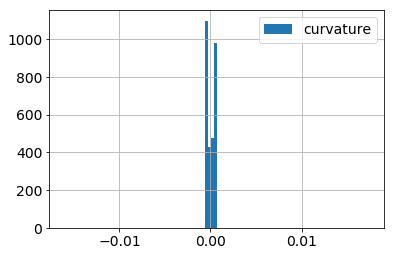

In [36]:
plt.figure()
triplets.curv.hist(density=True, bins=100, label='curvature')
plt.legend()
_ = _

## Prepare quadruplets

In [22]:
true_qplets = tracks_to_xplets(true_tracks, x=4)

qplets = pd.DataFrame(true_qplets, columns=['a', 'b', 'c', 'd'])

drz = [(
        angle_diff(compute_rz_angle(t[0], t[1]), compute_rz_angle(t[1], t[2])),
        angle_diff(compute_rz_angle(t[1], t[2]), compute_rz_angle(t[2], t[3])))
    for t in qplets.values]

ddrz = [angle_diff(a,b) for a,b in drz]

max_drz = [max(i) for i in drz]
max_drz_2 = [min(max(i), max([abs(np.pi - j) for j in i])) for i in drz]
dcurv = [np.abs(
            curvature(*hits.loc[t[:3]][['x','y']].values) - 
            curvature(*hits.loc[t[-3:]][['x','y']].values))  
         for t in qplets.values]



qplets['ddrz'] = ddrz
qplets['max_drz'] = max_drz
qplets['dcurv'] = dcurv

qplets['volayer_span'] = np.abs(hits.loc[qplets.d].volayer.values - hits.loc[qplets.a].volayer.values)

qplets.head()

,a,b,c,d,ddrz,max_drz,dcurv,volayer_span
0,23346,31387,38927,45412,0.000363,0.000407,0.000116,3
1,31387,38927,45412,77184,0.000859,0.001266,0.000070,3
2,38927,45412,77184,84457,0.001373,0.002639,0.000026,3
3,45412,77184,84457,91226,0.002313,0.002639,0.000033,3
4,19817,27902,34321,40692,0.000997,0.001128,0.000010,3


## Analyse quadruplets

In [23]:
qplets[['ddrz', 'max_drz', 'dcurv', 'volayer_span']].describe()

,ddrz,max_drz,dcurv,volayer_span
count,3567.000000,3567.000000,3.567000e+03,3567.000000
mean,0.004570,0.007865,4.763633e-05,3.058312
std,0.022244,0.038333,6.691985e-04,0.240274
min,0.000000,0.000000,5.884004e-09,3.000000
25%,0.000374,0.000829,4.785884e-06,3.000000
50%,0.001097,0.002111,1.093733e-05,3.000000
75%,0.003221,0.005528,2.155249e-05,3.000000
max,0.696198,0.971740,2.845133e-02,5.000000


In [24]:
qplets.volayer_span.value_counts()

3    3364
4     198
5       5
Name: volayer_span, dtype: int64

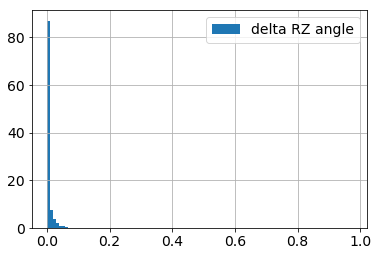

In [25]:
plt.figure(figsize=(6,4))
qplets.max_drz.hist(density=True, bins=100, label='delta RZ angle')
plt.legend()
_ = _

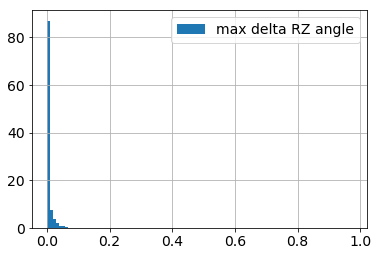

In [37]:
plt.figure(figsize=(6,4))
qplets.max_drz.hist(density=True, bins=100, label='max delta RZ angle')
plt.legend()
_ = _

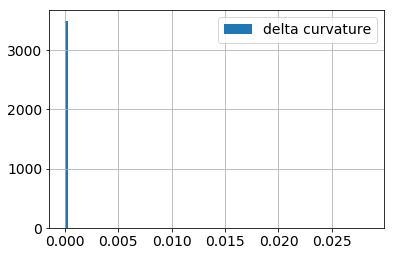

In [38]:
plt.figure(figsize=(6,4))
qplets.dcurv.hist(density=True, bins=100, label='delta curvature')
plt.legend()
_ = _

## View strength

In [28]:
class Config():

    cheat = False
    # === Hard cut

    #: Doublets can miss at most (max_layer_span - 1) layers.
    #: Note that triplets and quadruplets also have this limitation, i.e.
    #: any xplet will at most miss (max_layer_span - 1) layers
    max_layer_span = 2

    #: Maximum radius of curvature for a triplet. The curvature is computed using
    #: the *Mengel curvature*.
    tplet_max_curv = 5E-3
    #: Maximum (absolute) difference between the angles in the R-Z plane of the two doublets forming
    #: the triplet. The angles are defined as arctan(dz/dr).
    tplet_max_drz = 0.2

    #: Maximum difference between the radius of curvature of the two triplets forming the quadruplet.
    qplet_max_dcurv = 5E-4
    #: Maximum strength of a quadruplet. This cut is really efficient, but the actual value depends
    #: highly on the strength function parameters (see below)
    qplet_max_strength = -0.2

    #: Linear bias weight associated to triplets in the QUBO.
    qubo_bias_weight = -0.01
    #: Quadratic coupling strength associated to two conflicting triplets in the QUBO.
    #: Set it to 1 (other things being equal) to avoid conflicts.
    qubo_conflict_strength = 0.5

    # strength computation
    #: Factor of the numerator in the strength formula. Should be negative.
    num_multiplier = -1
    #: Ponderation between the curvature (X-Y plane) and the delta angle (R-Z plane) in the numerator.
    #: Should be a percentage (0 <= `xy_relative_strength` <= 1).
    xy_relative_strength = 0.5
    #: Exponent of the curvature (X-Y plane) in the strength formula. Should be >= 0.
    xy_power = 1
    #: Exponent of the delta angle (R-Z plane) in the strength formula. Should be >= 0.
    rz_power = 1
    #: Exponent of the "layer miss" in the strength formula (denominator). Should be >= 0.
    volayer_power = 2
    #: Clipping bounds of the strength. If defined, strength values outside those bounds will take the
    #: value of the bound.
    strength_bounds = None

In [29]:
def filter_qplets(config, qplets):
    mask = (qplets.dcurv <= config.qplet_max_dcurv) & \
           (qplets.max_drz < config.tplet_max_drz) & \
           (qplets.volayer_span > 3) & \
           (qplets.volayer_span <= 2 + config.max_layer_span)
    return qplets[mask], qplets[~mask]

In [30]:
def compute_strength(qplet) -> float:
    # Combine information about the layer miss, the alignment in the R-Z plane and the curvature in the X-Y plane.
    # The strength is negative, its range depending on the configuration (default: 1 >= strength >= max_strength)

    # normalised difference of curvature between the two triplets
    xy_strength = 1 - ((qplet.dcurv/config.qplet_max_dcurv) ** config.xy_power)

    # normalised [maximum] angle in the R-Z plane
    rz_strength = 1 - ((qplet.max_drz/config.tplet_max_drz) ** config.rz_power)

    # numerator: combine both X-Y and R-Z plane information
    numerator = config.num_multiplier * (
            config.xy_relative_strength * xy_strength +
            (1 - config.xy_relative_strength) * rz_strength
    )

    # denominator: shrink the strength proportional to the number of layer miss
    exceeding_volayer_span = qplet.volayer_span - 3
    denominator = (1 + exceeding_volayer_span) ** config.volayer_power

    strength = numerator / denominator

    # clip the strength if needed
    if config.strength_bounds is not None:
        strength = np.clip(strength, *config.strength_bounds)

    return strength

In [31]:
def plot_strengths(strengths):
    plt.figure(figsize=(8,4))
    plt.hist(strengths, bins=100)

### Using basic config

203, 196 => missing 3371


(196, 196, 3371)

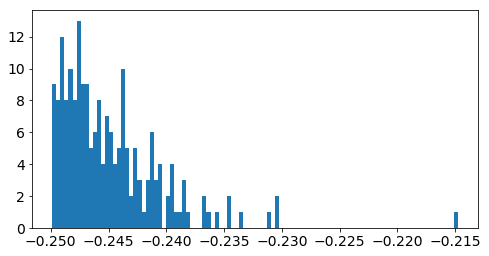

In [32]:
config = Config()
ins, outs = filter_qplets(config, qplets)
strengths = compute_strength(ins)
plot_strengths(strengths)
print(f'{len(qplets[qplets.volayer_span > 3])}, {len(ins)} => missing {len(outs)}')
len(strengths), len(ins), len(outs)

### Strengthening the cuts

3567, 196 => missing 3371


(196, 196, 3371)

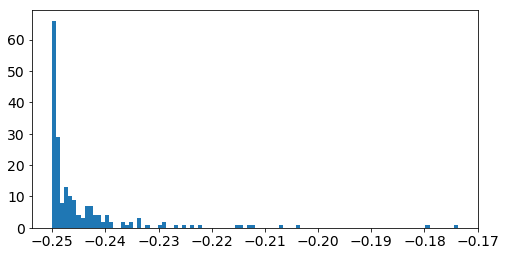

In [33]:
config = Config()

config.tplet_max_curv = 8E-4 # instead of 5E-3 / 0.005
config.tplet_max_drz  = 0.1 # instead of 0.2
config.qplet_max_dcurv = 1E-4 # instead of 5E-4 / 0.0005

config.xy_power = 2 # instead of 1
config.rz_power = 2 # instead of 1

ins, outs = filter_qplets(config, qplets)
strengths = compute_strength(ins)
plot_strengths(strengths)
print(f'{len(qplets)}, {len(ins)} => missing {len(outs)}')
len(strengths), len(ins), len(outs)

3567, 196 => missing 3371


(196, 196, 3371)

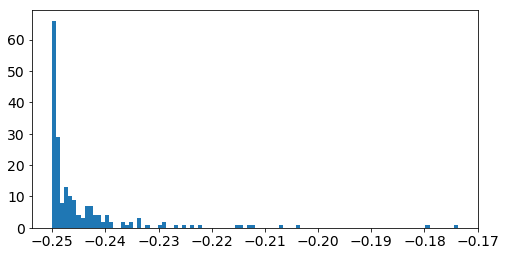

In [34]:
config.xy_power = 2 # instead of 1
config.rz_power = 2 # instead of 1

ins, outs = filter_qplets(config, qplets)
strengths = compute_strength(ins)
plot_strengths(strengths)
print(f'{len(qplets)}, {len(ins)} => missing {len(outs)}')
len(strengths), len(ins), len(outs)